In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from functools import partial

In [4]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, r)

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

### Newton's second law for the constrained mass:
$$T-Mg=M\ddot r$$
$$T = M\ddot r + Mg$$

### Newton's second law (in polar form) for the swinging mass:
#### Radius:
$$a_r=gcos\theta - \frac{T}{m}=gcos\theta - \frac{Mg}{m} - \frac{M\ddot r}{m}=gcos\theta - \mu g - \mu \ddot r = \ddot r-r\dot\theta^2$$
$$\ddot r = \frac{g(cos\theta-\mu) + r\dot\theta^2}{1+\mu}$$
#### Angle:
$$a_\theta=-gsin\theta=r\ddot\theta+2\dot r \dot\theta$$
$$\ddot\theta = \frac{-gsin\theta-2\dot r \dot\theta}{r}$$

In [5]:
g = 9.81
# offsets for relevant quantities in the state array
R = 0
RDOT = 1
THETA = 2
THETADOT = 3

def ddt(mu, state, t):
    #some of these have been complicated with newton's 2nd law in polar coord form
    rdotdot = (g*(-mu + np.cos(state[THETA])) + state[R]*state[THETADOT]**2) / (1+mu)
    thetadotdot = (-g*np.sin(state[THETA])-2*state[RDOT]*state[THETADOT])/state[R]
    return np.array([state[RDOT],rdotdot,state[THETADOT],thetadotdot]) #r, rdot, theta, thetadot

def rk4(mu, state, t, dt):
    f0 = ddt(mu, state, t)
    f1 = ddt(mu, state+f0*(dt/2), t + dt/2)
    f2 = ddt(mu, state+f1*(dt/2), t + dt/2)
    f3 = ddt(mu, state+f2*(dt), t + dt)
    s_next = state + (f0 + 2 * f1 + 2 * f2 + f3) * dt / 6
    return s_next

In [6]:
def SAM(mu, init_state, t, show):
    states=[init_state] #this captures all necessary params: r, rdot, theta, thetadot
    times = [0]
    dt = 0.005
    threshold = 0.005

    for i in range(int(t/dt)):
        if(states[-1][0] < threshold * init_state[0]):
            print("Possible singularity. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        if(states[-1][0] > init_state[0]/threshold):
            print("Possible unbounded solution. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        states.append(rk4(mu, states[-1], times[-1], dt))
        times.append(times[-1] + dt)
        
    
    # transform and transpose
    states = np.array(states)
    states = states.transpose()

    if show:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.set_theta_zero_location("S")
        ax.plot(states[THETA], states[R], color='r', linewidth=1)
        plt.title("$\mu = %.3f$, $r_0 = %.3f$, $\\dot{r_0} = %.3f$, $\\theta_0 = %.3f$, $\\dot{\\theta_0} = %.3f$" % (mu, init_state[0], init_state[1], init_state[2], init_state[3]))
        ax.grid(True)
    return states

array([[ 2.        ,  1.99992336,  1.99969344, ...,  1.5317064 ,
         1.54007809,  1.5484863 ],
       [ 0.        , -0.03065742, -0.06130808, ...,  1.67028308,
         1.67819017,  1.68489611],
       [ 1.57079633,  1.57073501,  1.57055105, ...,  1.00594462,
         1.0217697 ,  1.03728818],
       [ 0.        , -0.02452657, -0.04906253, ...,  3.19586985,
         3.13425687,  3.07323683]])

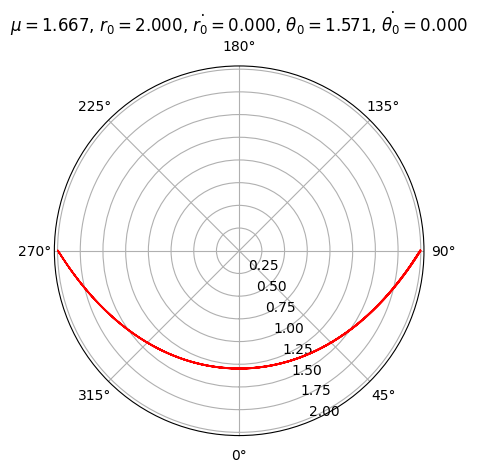

In [7]:
SAM(1.667, np.array([2,0,np.pi/2,0]), 10, True) #known periodic orbit

Possible singularity. Stopping simulation. (r=0.005)


array([[ 2.00000000e+00,  1.99988852e+00,  1.99955410e+00, ...,
         6.05366793e-02,  3.14300347e-02,  5.41272762e-03],
       [ 0.00000000e+00, -4.45906357e-02, -8.91796305e-02, ...,
        -5.83369999e+00, -5.77390526e+00, -3.48916623e+00],
       [ 1.57079633e+00,  1.57073501e+00,  1.57055103e+00, ...,
        -8.79982224e+00, -8.44224282e+00, -5.21208936e+00],
       [ 0.00000000e+00, -2.45272785e-02, -4.90682317e-02, ...,
         3.76946482e+01,  1.39774280e+02,  3.82272899e+03]])

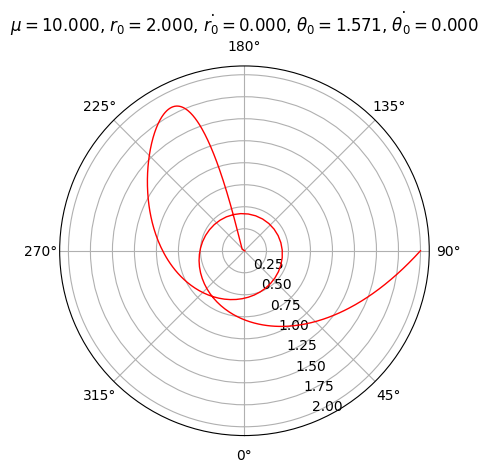

In [8]:
SAM(10, np.array([2,0,np.pi/2,0]), 10, True) #known singular orbit

array([[ 2.        ,  1.9849202 ,  1.96968082, ...,  1.60187449,
         1.58964859,  1.57720726],
       [-3.        , -3.03191923, -3.06382843, ..., -2.42359032,
        -2.46674645, -2.50976019],
       [ 0.1       ,  0.1035203 ,  0.10708193, ..., -2.02527575,
        -2.02035202, -2.01521123],
       [ 0.7       ,  0.70815676,  0.71652971, ...,  0.96348537,
         1.00622627,  1.05031802]])

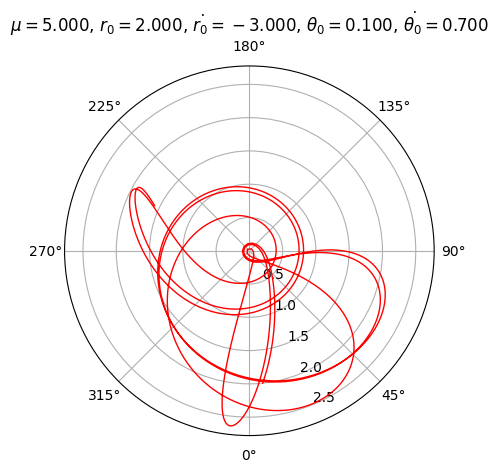

In [9]:
SAM(5, np.array([2,-3,0.1,0.7]), 10, True) #some initial velocity

In [10]:
DOT_SIZE = 90
MIN_STRING_LENGTH = 1.75
DISTANCE_BETWEEN_PULLEYS = 0.5

def update(frame, dots, history, string, res, interval, string_length):
    # prevent t from going beyond the end
    t = frame*int(interval/5)
    t_end = len(res[0])-1
    t = min(t, t_end)

    # mutate path history    
    history.set_xdata(res[THETA][:t])
    history.set_ydata(res[R][:t])
    
    theta = res[THETA][t]
    r = res[R][t]
    
    # mutate swinging mass location
    swinging_dot = dots[0]
    swinging_dot.set_offsets([theta, r])
    
    # mutate vertical mass location
    vertical_dot = dots[1]
    remaining_string_length = string_length - DISTANCE_BETWEEN_PULLEYS - r
    
    alpha = np.arctan2(remaining_string_length, DISTANCE_BETWEEN_PULLEYS)
    angle = -np.pi/2 + alpha
    distance = np.sqrt(remaining_string_length**2 + DISTANCE_BETWEEN_PULLEYS**2)
    vertical_dot.set_offsets([angle, distance])
    
    # mutate string
    positions = np.array([[angle, distance],
        [-np.pi/2, DISTANCE_BETWEEN_PULLEYS],
        [0, 0],
        [theta, r]])
    string.set_data(np.transpose(positions))
    
    return [history, swinging_dot, vertical_dot, string]

def anim(mu, state, t, interval):
    # data for animation
    res = SAM(mu, state, t, False)

    # find string length such that remaining string length is not negative
    string_length = max(MIN_STRING_LENGTH, max(res[R]) + 0.1 + DISTANCE_BETWEEN_PULLEYS)
    
    # set up polar coords
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location("S")
    history = ax.plot(res[THETA], res[R], color='r', linewidth=1)[0] # past movement
    ax.grid(True)
    
    #ensure that vertical dot does not go out of limits
    ax.set_ylim([0, np.sqrt((string_length-DISTANCE_BETWEEN_PULLEYS)**2+DISTANCE_BETWEEN_PULLEYS**2)])
    
    initial_theta = res[THETA][0]
    initial_r = res[R][0]
    
    swinging_dot = ax.scatter(initial_theta, initial_r, s=DOT_SIZE, c='black')
    vertical_dot = ax.scatter(initial_theta, initial_r, s=DOT_SIZE, c='blue')

    string = ax.plot(initial_theta, initial_r, color='gray', linewidth=1)[0] #idk why it returns it in a list

    ani = animation.FuncAnimation(fig=fig, func=partial(
        update, 
        history=history, 
        dots=[swinging_dot, vertical_dot],
        string=string,
        res=res, 
        interval=interval,
        string_length=string_length), frames=int(len(res[0])*5/interval), interval=interval)

    # filename checks and file creation
    i = 1
    filename = "gifs/example_mu%.3f.gif" % (mu)
    if os.path.exists(filename):
        while os.path.exists("gifs/example_mu%.3f_%s.gif" % (mu, i)):
            i += 1
        filename = "gifs/example_mu%.3f_%s.gif" % (mu, i)
    ani.save(filename=filename, writer="pillow", fps=int(1000/interval))

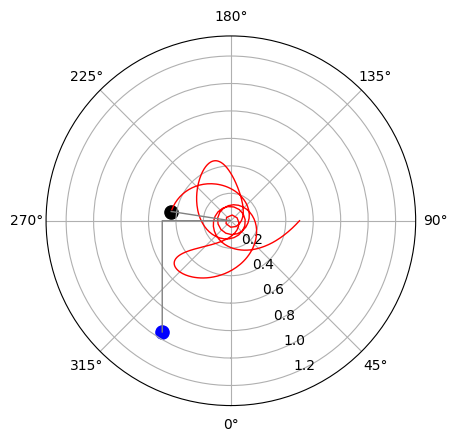

In [11]:
anim(mu=10.3, state=np.array([0.5, 0, np.pi/2, 0]), t=2, interval=30)

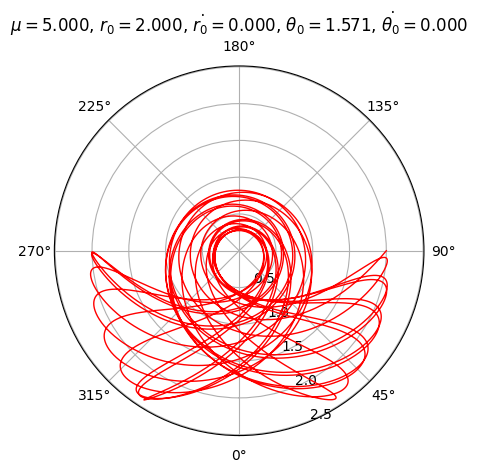

In [12]:
result = SAM(5, np.array([2,0,np.pi/2,0]), 30, True)

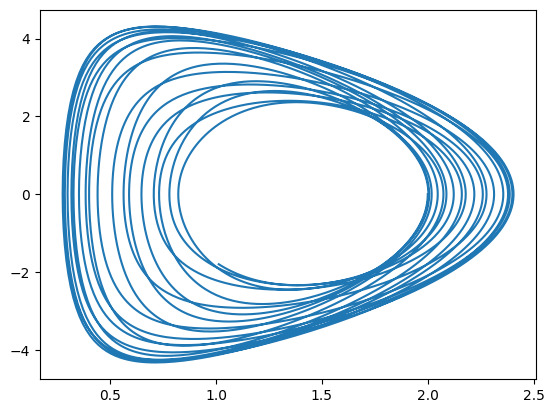

In [13]:
plt.plot(result[R], result[RDOT])

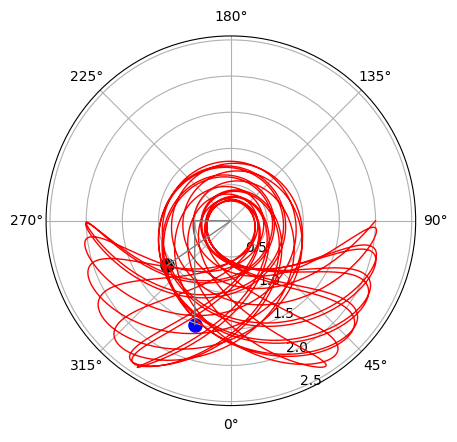

In [14]:
anim(mu=5, state=np.array([2, 0, np.pi/2, 0]), t=30, interval=30)

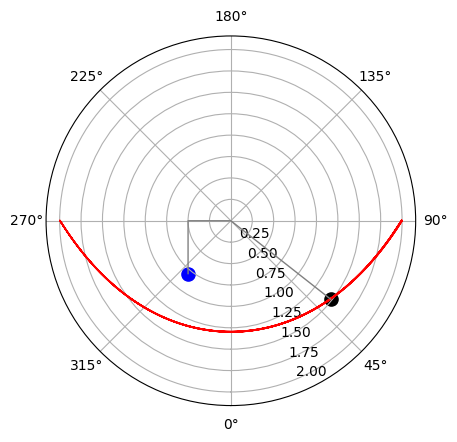

In [15]:
anim(1.667, np.array([2,0,np.pi/2,0]), t=10, interval=30) #known periodic orbit

# 3 Dimensions

### Newton's second law for the constrained mass:
$$T-Mg=M\ddot r$$
$$T = M\ddot r + Mg$$

### Coordinate system:
We will be using a spherical coordinate system with the origin at the point where the swinging mass' rope connects to the fixed part of the rope. $\theta$ will be measured upward from the downward vertical, and $\phi$ will be measured *clockwise* from an arbitrary direction, so that the coordinate system remains right-handed.

![](img/coords.jpg "Coordinate system")

### Newton's laws for spherical coordinates:
Note that the gravitational force is only in the r,$\theta$ directions, and tension in the r direction. So $\ddot \phi$ is 0, and we can use our equations from the first part with minor additions for the extra azimuthal angle $\phi$.
#### $r$:
$$a_r = g\cos\theta - \mu g - \mu \ddot r = \ddot r - r\dot\theta^2 - r\dot\phi^2\sin^2\theta$$
$$\ddot r = \frac{g(\cos\theta-\mu) + r\dot\theta^2 + r\dot\phi^2\sin^2\theta}{1+\mu}$$
#### $\theta$:
$$a_\theta = -g\sin\theta = r\ddot\theta + 2\dot r\dot\theta - r\dot\phi^2\sin\theta\cos\theta$$
$$\ddot\theta = \frac{-g\sin\theta-2\dot r \dot\theta}{r} + \dot\phi^2\sin\theta\cos\theta$$
#### $\phi$:
$$a_\phi = 0 = 2\dot r\dot\phi\sin\theta + r\ddot\phi\sin\theta + 2r\dot\theta\dot\phi\cos\theta$$
$$\ddot\phi = \frac{- 2\dot r\dot\phi\sin\theta - 2r\dot\theta\dot\phi\cos\theta}{r\sin\theta}
= - \frac{ 2\dot r\dot\phi}{r} - \frac{2\dot\theta\dot\phi}{\tan\theta}
= - 2\dot\phi(\frac{\dot r}{r} + \frac{\dot\theta}{\tan\theta})$$

In [16]:
# new coord variables
PHI = 4
PHIDOT = 5

def ddt3d(mu, state, t):
    rdotdot = (g*(-mu + np.cos(state[THETA])) + state[R]*state[THETADOT]**2 + state[R]*state[PHIDOT]**2*np.sin(state[THETA])**2) / (1+mu)
    thetadotdot = (-g*np.sin(state[THETA])-2*state[RDOT]*state[THETADOT])/state[R] + state[PHIDOT]**2*np.sin(state[THETA])*np.cos(state[THETA])
    phidotdot = -2*state[PHIDOT]*(state[RDOT]/state[R] + state[THETADOT]/np.tan(state[THETA]))
    return np.array([state[RDOT],rdotdot,state[THETADOT],thetadotdot,state[PHIDOT],phidotdot]) #r, rdot, theta, thetadot, phi, phidot

def rk43d(mu, state, t, dt):
    f0 = ddt3d(mu, state, t)
    f1 = ddt3d(mu, state+f0*(dt/2), t + dt/2)
    f2 = ddt3d(mu, state+f1*(dt/2), t + dt/2)
    f3 = ddt3d(mu, state+f2*(dt), t + dt)
    s_next = state + (f0 + 2 * f1 + 2 * f2 + f3) * dt / 6
    return s_next

In [17]:
# coord conversion tools

def sph2cart(r, theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return (x, y, z)

def cart2sph(x, y, z):
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    return (r, theta, phi)

In [18]:
def SAM3d(mu, init_state, t, show, figsize=(6.4, 4.8)):
    states=[init_state] #this captures all necessary params: r, rdot, theta, thetadot
    times = [0]
    dt = 0.005
    threshold = 0.005

    for i in range(int(t/dt)):
        if(states[-1][0] < threshold * init_state[0]):
            print("Possible singularity. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        if(states[-1][0] > init_state[0]/threshold):
            print("Possible unbounded solution. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        states.append(rk43d(mu, states[-1], times[-1], dt))
        times.append(times[-1] + dt)
        
    
    # transform and transpose
    states = np.array(states)
    states = states.transpose()

    if show:
        fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=figsize)
        temp = sph2cart(states[R], states[THETA], states[PHI])
        ax.plot(temp[0], temp[1], temp[2], color='r', linewidth=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        limit = max(states[R])
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.set_zlim(-limit, limit)
        ax.invert_yaxis()
        ax.invert_zaxis()
        plt.title("$\\mu = %.3f$, $r_0 = %.3f$, $\\dot{r_0} = %.3f$, $\\theta_0 = %.3f$, $\\dot{\\theta_0} = %.3f$, $\\phi_0 = %.3f$, $\\dot{\\phi_0} = %.3f$" % 
                  (mu, init_state[R], init_state[RDOT], init_state[THETA], init_state[THETADOT], init_state[PHI], init_state[PHIDOT]))
    return states

sanity check with $\dot\phi$ as 0 so it becomes a 2d solution

array([[ 2.        ,  1.99989781,  1.99959126, ...,  1.03084506,
         1.02161724,  1.01254157],
       [ 0.        , -0.0408745 , -0.08174599, ..., -1.86050403,
        -1.83048543, -1.79964799],
       [ 1.57079633,  1.57073501,  1.57055104, ..., -1.13238262,
        -1.1768333 , -1.22186392],
       [ 0.        , -0.02452709, -0.04906671, ..., -8.83202593,
        -8.9481919 , -9.06398544],
       [-0.05      , -0.05      , -0.05      , ..., -0.05      ,
        -0.05      , -0.05      ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

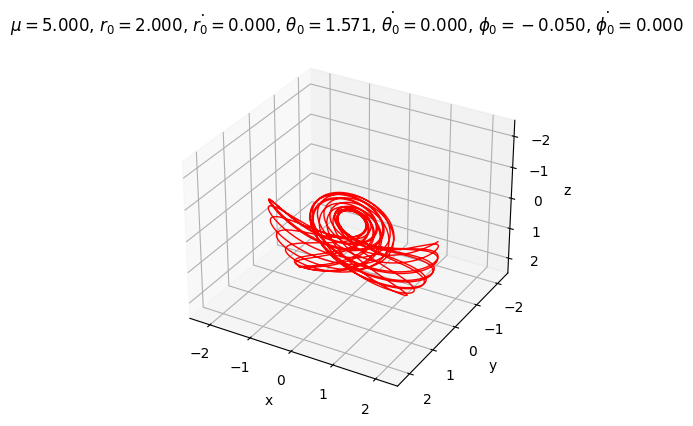

In [19]:
SAM3d(5, [2, 0, np.pi/2, 0, -.05, 0], 30, True)

array([[ 2.        ,  1.99992336,  1.99969344, ...,  1.9952565 ,
         1.9939813 ,  1.99255412],
       [ 0.        , -0.03065742, -0.06130808, ..., -0.23982397,
        -0.27024835, -0.30061249],
       [ 1.57079633,  1.57073501,  1.57055105, ..., -1.56708553,
        -1.56606258, -1.56491517],
       [ 0.        , -0.02452657, -0.04906253, ...,  0.19216873,
         0.21702143,  0.2419577 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

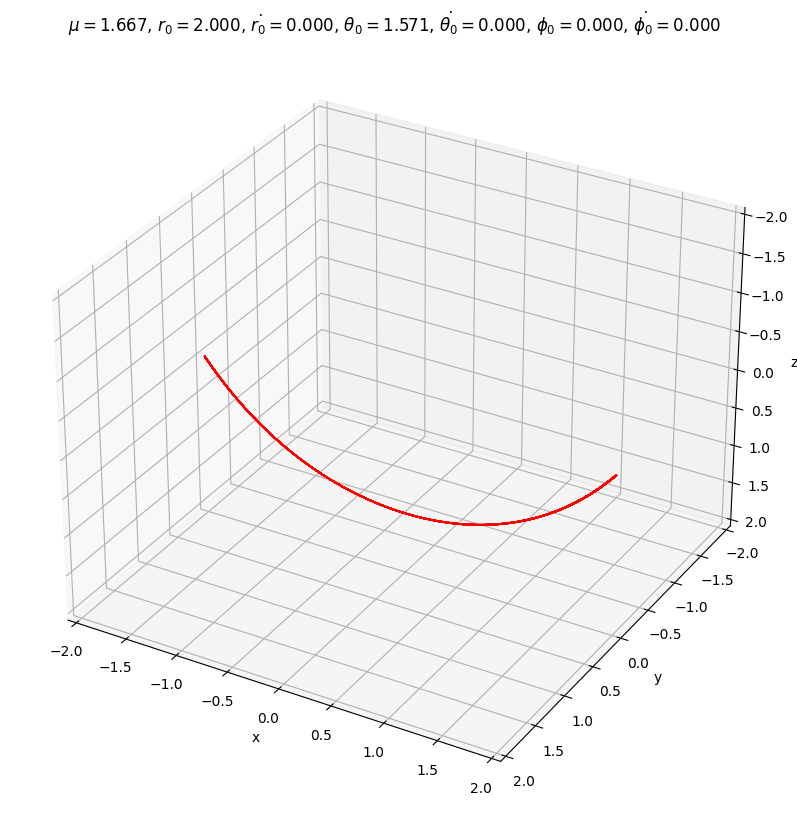

In [26]:
SAM3d(1.667, [2, 0, np.pi/2, 0, 0, 0], 30, True, figsize=(160/9, 10)) # known periodic orbit

In [20]:
DOT_SIZE_3D = 50

def update3d(frame, dots, history, string, res, interval, string_length):
    # prevent t from going beyond the end
    t = frame*int(interval/5)
    t_end = len(res[0])-1
    t = min(t, t_end)

    # change from spherical to cartesian since no such thing as spherical plot
    cart = sph2cart(res[R], res[THETA], res[PHI])

    # mutate path history    
    history.set_data_3d(cart[0][:t], cart[1][:t], cart[2][:t])
    
    r = res[R][t]
    
    # mutate swinging mass location
    swinging_dot = dots[0]
    swinging_dot._offsets3d = ([cart[0][t]], [cart[1][t]], [cart[2][t]])
    
    # mutate vertical mass location
    vertical_dot = dots[1]
    remaining_string_length = string_length - DISTANCE_BETWEEN_PULLEYS - r
    vertical_dot._offsets3d = ([-DISTANCE_BETWEEN_PULLEYS], [0], [remaining_string_length])
    
    # mutate string
    positions = np.array([[-DISTANCE_BETWEEN_PULLEYS, 0, remaining_string_length], #vertical mass
        [-DISTANCE_BETWEEN_PULLEYS, 0, 0], # vertical pulley
        [0, 0, 0], #swinging pulley
        [cart[0][t], cart[1][t], cart[2][t]]]) #swinging mass
    string.set_data_3d(np.transpose(positions))
    
    return [history, swinging_dot, vertical_dot, string]

def anim3d(mu, state, t, interval, figsize=(6.4, 4.8)):
    # data for animation
    res = SAM3d(mu, state, t, False)

    # find string length such that remaining string length is not negative
    string_length = max(MIN_STRING_LENGTH, max(res[R]) + 0.1 + DISTANCE_BETWEEN_PULLEYS)
    
    # set up plot
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=figsize)
    plt.figure(figsize=figsize)
    cart = sph2cart(res[R], res[THETA], res[PHI])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    limit = max(res[R])
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit, limit)
    ax.invert_yaxis()
    ax.invert_zaxis()
    history = ax.plot(cart[0], cart[1], cart[2], color='r', linewidth=1)[0]
    
    initial_x = cart[0][0]
    initial_y = cart[1][0]
    initial_z = cart[2][0]
    
    swinging_dot = ax.scatter(initial_x, initial_y, initial_z, s=DOT_SIZE_3D, c='black')
    vertical_dot = ax.scatter(initial_x, initial_y, initial_z, s=DOT_SIZE_3D, c='blue')

    string = ax.plot(initial_x, initial_y, initial_z, color='gray', linewidth=1)[0] #idk why it returns it in a list

    ani = animation.FuncAnimation(fig=fig, func=partial(
        update3d, 
        history=history, 
        dots=[swinging_dot, vertical_dot],
        string=string,
        res=res, 
        interval=interval,
        string_length=string_length), frames=int(len(res[0])*5/interval), interval=interval)

    # filename checks and file creation
    i = 1
    filename = "gifs/3d_mu%.3f.gif" % (mu)
    if os.path.exists(filename):
        while os.path.exists("gifs/3d_mu%.3f_%s.gif" % (mu, i)):
            i += 1
        filename = "gifs/3d_mu%.3f_%s.gif" % (mu, i)
    ani.save(filename=filename, writer="pillow", fps=int(1000/interval))

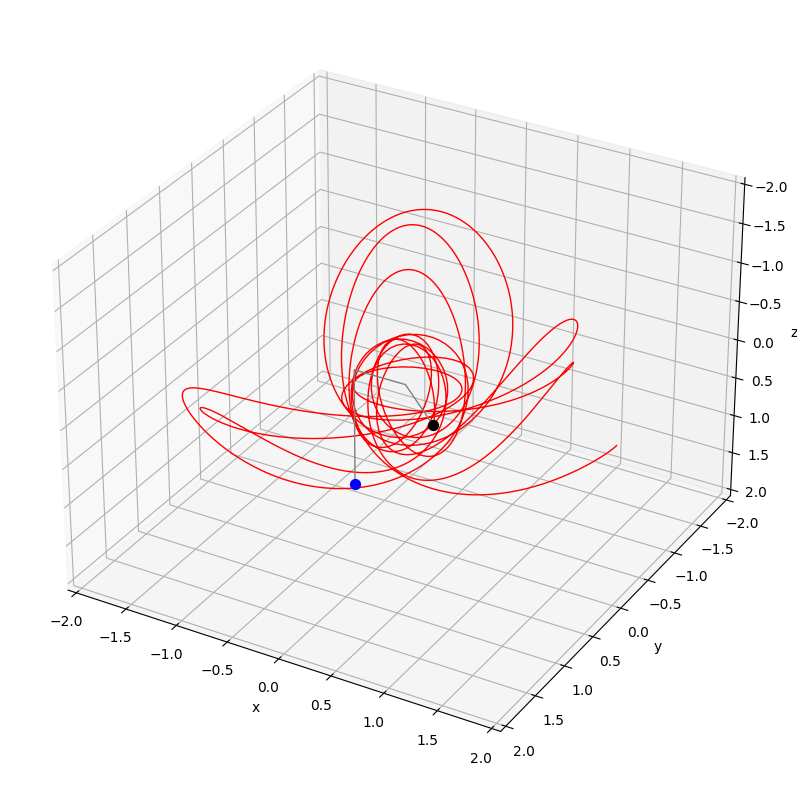

<Figure size 1777.78x1000 with 0 Axes>

In [21]:
anim3d(mu=10, state=np.array([2, 0, np.pi/2, 0, 0, 0.8]), t=10, interval=30, figsize=(160/9, 10))

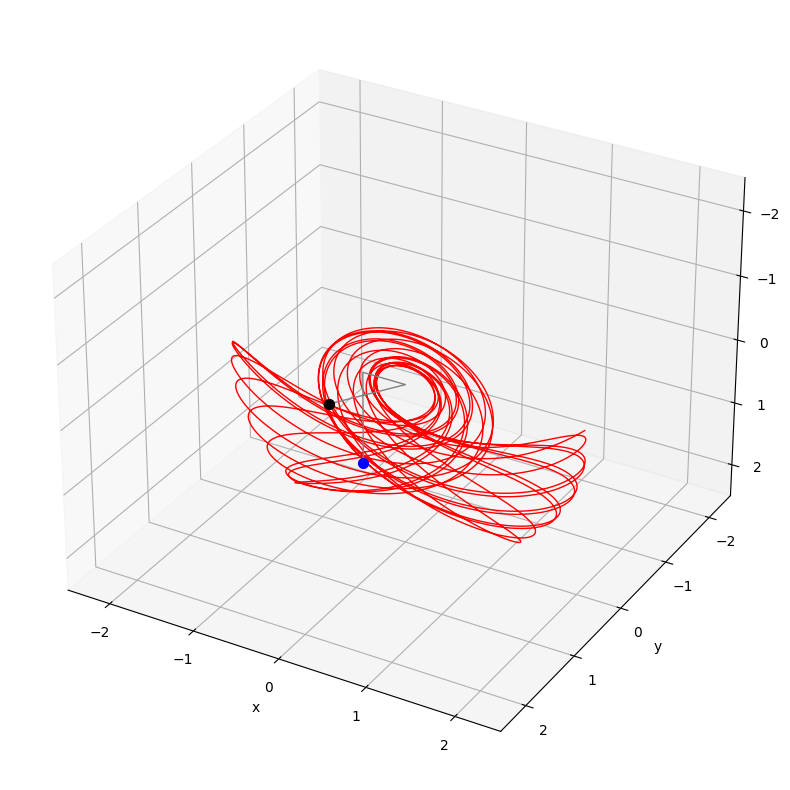

<Figure size 1777.78x1000 with 0 Axes>

In [22]:
anim3d(mu=5, state=np.array([2, 0, np.pi/2, 0, -.05, 0]), t=30, interval=30, figsize=(160/9, 10))

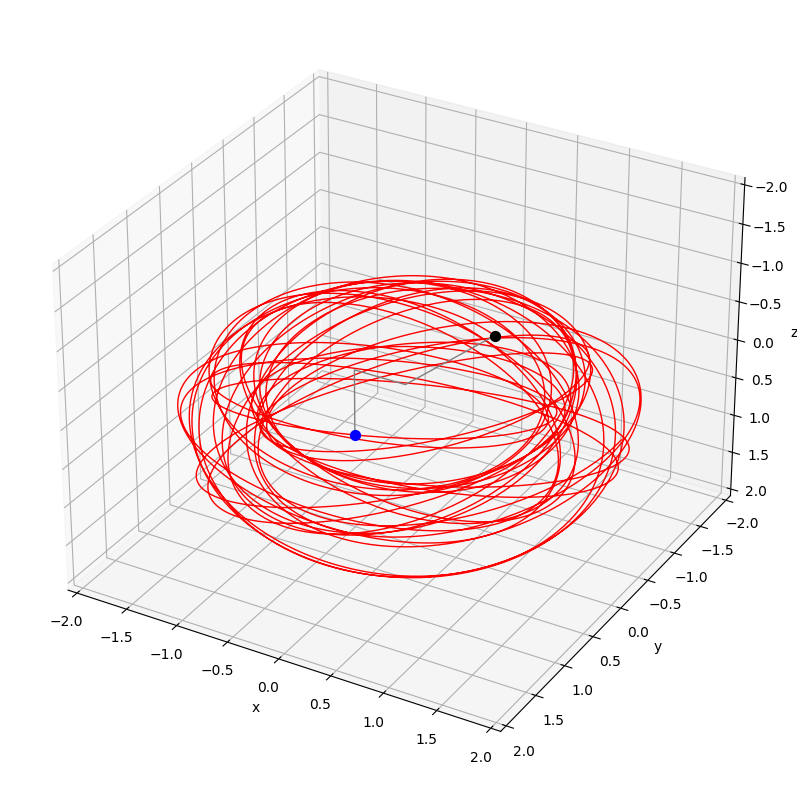

<Figure size 1777.78x1000 with 0 Axes>

In [24]:
anim3d(mu=5, state=np.array([2, 0, np.pi/2, 0, -.05, np.pi]), t=30, interval=30, figsize=(160/9, 10))